In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from segmentation_models.models import Unet
import cv2
from segmentation_models.utils import predict_big_image
import os
import sklearn
from sklearn.metrics import confusion_matrix, f1_score, jaccard_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
imdir_test = "./Test/Patch/Images/"
mdir_test = "./Test/Patch/Annotations/"


test_imgs = tf.keras.utils.image_dataset_from_directory(
    imdir_test,
    labels=None,
    batch_size=8,
    image_size=(384, 384),
    color_mode="rgb",
    seed=42,
)
test_masks = tf.keras.utils.image_dataset_from_directory(
    mdir_test,
    labels=None,
    batch_size=8,
    image_size=(384, 384),
    color_mode="grayscale",
    seed=42,
)

test_ds = tf.data.Dataset.zip((test_imgs, test_masks))

Found 250 files belonging to 1 classes.
Found 250 files belonging to 1 classes.


In [19]:
LUT = np.zeros(shape=(7,3), dtype=np.uint8)

LUT[0] = [0, 0, 0]          # Background
LUT[1] = [244, 229, 136]    # WDF
LUT[2] = [104, 180, 46]     # Swamp
LUT[3] = [42, 75, 155]      # Organic
LUT[4] = [241, 137, 24]     # Sand
LUT[5] = [128, 192, 123]    # PDF
LUT[6] = [106, 69, 149]     # ProDelta

In [ ]:
for img, mask in test_ds.take(1):

    for i in range(8):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
        ax1.imshow(img[i].numpy().astype(np.uint8))
        ax2.imshow(LUT[mask[i].numpy().astype('uint8')[..., 0]])
        # ax1.imshow(LUT[mask[i].numpy().astype('uint8')[..., 0]], alpha=0.2)
        ax1.axis('off') ; ax2.axis('off')

In [21]:
model = Unet((384, 384, 3), backbone="efficientnetb3", classes=7, final_activation='softmax')
model.load_weights('BEST_effnetb3_MAN_B3_2.h5')

In [ ]:
predictions = []
labels = []

for x, y in test_ds:

    pred = model.predict(x)

    pred = tf.argmax(pred, axis=-1)

    predictions.append(pred)

    labels.append(y.numpy())

In [24]:
prediction_array = np.concatenate(predictions, axis=0)
prediction_array = np.ravel(prediction_array)

labels_array = np.concatenate(labels, axis=0)
labels_array = np.ravel(labels_array)


((36864000,), (36864000,))

In [25]:
f1 = f1_score(y_true=labels_array, y_pred=prediction_array, average='weighted')

0.9360150671928126

In [30]:
iou = jaccard_score(y_true=labels_array, y_pred=prediction_array, average='weighted')

0.8841491915868414

In [27]:
acc = balanced_accuracy_score(y_true=labels_array, y_pred=prediction_array)

0.9046602576584831

In [19]:
names = [
"Background",
"WDFP",
"Swamp",
"Organic Layer",
"Sands",
"PDF",
"Prodelta",]

cm = confusion_matrix(labels_array, prediction_array, normalize='true')

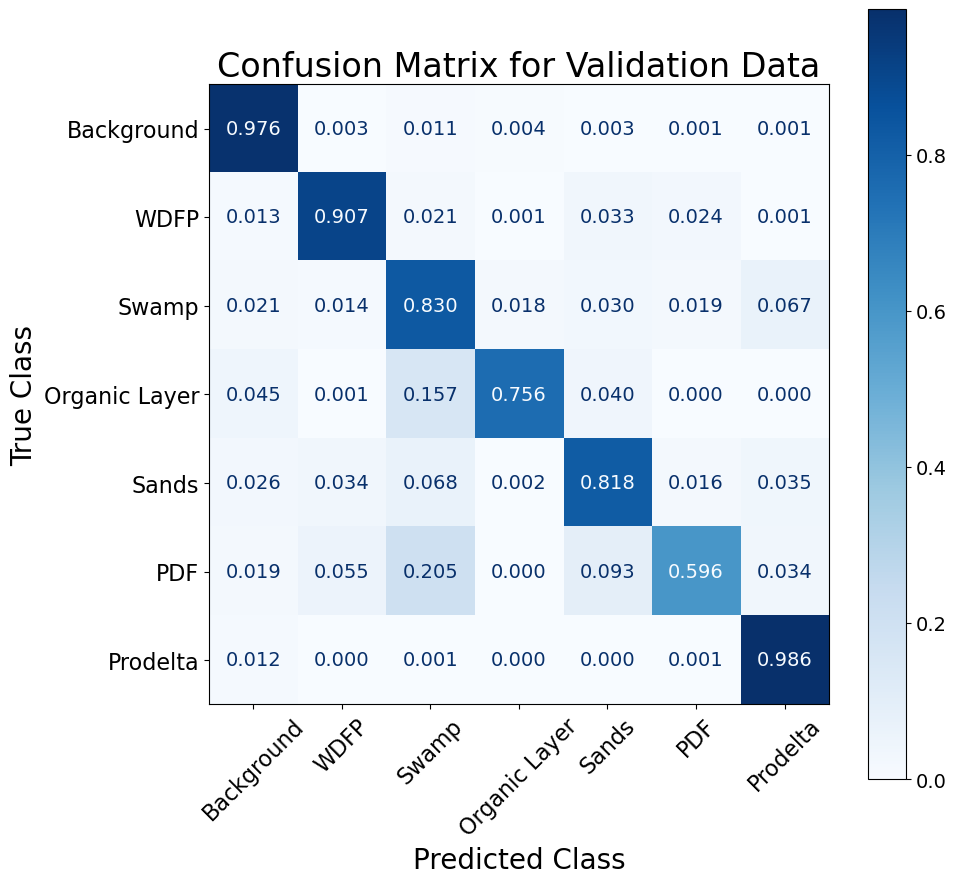

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.rcParams.update({'font.size': 14})

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45, values_format='.3f') #Blues
ax.set_title('Confusion Matrix for Validation Data', fontsize=24)
ax.set_ylabel('True Class', fontsize=20)
ax.set_xlabel('Predicted Class', fontsize=20)

ax.tick_params(axis='both', labelsize=16)

plt.savefig('confusion_matrix_test_16_02_23.svg', bbox_inches='tight')